In [4]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

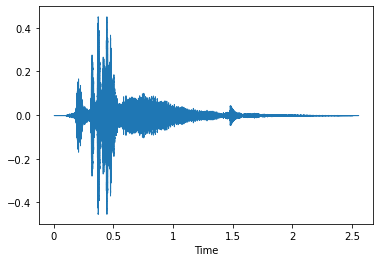

In [12]:
file_name='audio/Car/mixkit-car-engine-start-1566.wav'

audio_data, sampling_rate = librosa.load(file_name)
librosa.display.waveshow(audio_data,sr=sampling_rate)
ipd.Audio(file_name)

audio_data

In [14]:
sampling_rate

22050

In [31]:
!python prepare_csv.py

                                           file_name  class
0  C:\Users\Unkown\Desktop\AI_Projects\Twitts_cla...    Car
1  C:\Users\Unkown\Desktop\AI_Projects\Twitts_cla...    Car
2  C:\Users\Unkown\Desktop\AI_Projects\Twitts_cla...    Car
3  C:\Users\Unkown\Desktop\AI_Projects\Twitts_cla...    Car
4  C:\Users\Unkown\Desktop\AI_Projects\Twitts_cla...  Eagle
5  C:\Users\Unkown\Desktop\AI_Projects\Twitts_cla...  Eagle
6  C:\Users\Unkown\Desktop\AI_Projects\Twitts_cla...  Eagle
7  C:\Users\Unkown\Desktop\AI_Projects\Twitts_cla...  Eagle


In [50]:
import pandas as pd

metadata = pd.read_csv('myData.csv')
num_label = len(metadata['class'].unique())
metadata['class'].value_counts()

Car      4
Eagle    4
Name: class, dtype: int64

In [34]:
# get pattern from the random file 'audio_data'
mfccs = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)
mfccs

array([[-6.0323895e+02, -6.0323895e+02, -6.0323895e+02, ...,
        -5.9899890e+02, -6.0239996e+02, -6.0323895e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         5.9741979e+00,  1.1832876e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         5.9081101e+00,  1.1734238e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -9.3376637e-01, -2.5025430e-01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.0545676e-01, -2.6049238e-01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -6.7114294e-01, -2.7021971e-01,  0.0000000e+00]], dtype=float32)

In [35]:
# function that extract features
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [36]:
from tqdm import tqdm

extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = row['file_name']
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

8it [00:00, 30.53it/s]


In [40]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df

,feature,class
0,"[-201.37704, 112.620255, -26.709906, 28.464378...",Car
1,"[-402.50232, 61.699894, 5.1527915, 26.03257, 1...",Car
2,"[-42.80152, 27.585606, -35.583534, 12.56069, -...",Car
3,"[-133.09457, 134.2189, -14.768551, 23.870815, ...",Car
4,"[-199.13995, 116.4059, -123.49991, 60.68014, 2...",Eagle
5,"[-68.2385, 51.75626, -111.918304, 53.614853, -...",Eagle
6,"[-296.63446, 94.03138, -115.88366, 77.12701, 3...",Eagle
7,"[-206.53246, 93.59267, -159.28691, 41.785645, ...",Eagle


In [41]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [44]:
# encoded classses (eg. [1, 0]==>Car  /   [0, 1]==>Eagle)
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [45]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [51]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_label))
model.add(Activation('softmax'))

In [53]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 10000
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                                verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10000
1/1 [==============================] - ETA: 0s - loss: 1.1822 - accuracy: 0.8333
Epoch 1: val_loss improved from inf to 0.00003, saving model to saved_models\audio_classification.hdf5
1/1 [==============================] - 0s 62ms/step - loss: 1.1822 - accuracy: 0.8333 - val_loss: 2.6762e-05 - val_accuracy: 1.0000
Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.00003 to 0.00002, saving model to saved_models\audio_classification.hdf5
1/1 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.3960e-05 - val_accuracy: 1.0000
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.8333
Epoch 3: val_loss improved from 0.00002 to 0.00002, saving model to saved_models\audio_classification.hdf5
1/1 [==============================] - 0s 39ms/step - loss: 0.3359 - accuracy: 0.8333 - val_loss: 2.3186e-05 - val_accuracy: 1

1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 25: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.2517e-06 - val_accuracy: 1.0000
Epoch 26/10000
1/1 [==============================] - ETA: 0s - loss: 1.1126e-06 - accuracy: 1.0000
Epoch 26: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 1.1126e-06 - accuracy: 1.0000 - val_loss: 1.2517e-06 - val_accuracy: 1.0000
Epoch 27/10000
1/1 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 1.0000
Epoch 27: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 30ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 1.2517e-06 - val_accuracy: 1.0000
Epoch 28/10000
1/1 [==============================] - ETA: 0s - loss: 9.3975e-06 - accuracy: 1.0000
Epoch 28: val_loss did not improve from 0.00000
1/1 [==================

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 52/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 52: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 53/10000
1/1 [==============================] - ETA: 0s - loss: 2.0026e-05 - accuracy: 1.0000
Epoch 53: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 2.0026e-05 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 54/10000
1/1 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 1.0000
Epoch 54: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0623 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 55/10000
1/1 [

1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 80: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 81/10000
1/1 [==============================] - ETA: 0s - loss: 2.8037 - accuracy: 0.8333
Epoch 81: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 2.8037 - accuracy: 0.8333 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 82/10000
1/1 [==============================] - ETA: 0s - loss: 5.9605e-08 - accuracy: 1.0000
Epoch 82: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 5.9605e-08 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 83/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 83: val_loss did not improve from 0.00000
1/1 [==================

Epoch 109/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 109: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.3709e-06 - val_accuracy: 1.0000
Epoch 110/10000
1/1 [==============================] - ETA: 0s - loss: 9.0001e-06 - accuracy: 1.0000
Epoch 110: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 35ms/step - loss: 9.0001e-06 - accuracy: 1.0000 - val_loss: 1.5497e-06 - val_accuracy: 1.0000
Epoch 111/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 111: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 61ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.6689e-06 - val_accuracy: 1.0000
Epoch 112/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 112: val_loss did not improve from 

Epoch 138/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 138: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.6093e-06 - val_accuracy: 1.0000
Epoch 139/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 139: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4901e-06 - val_accuracy: 1.0000
Epoch 140/10000
1/1 [==============================] - ETA: 0s - loss: 8.0937e-04 - accuracy: 1.0000
Epoch 140: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 8.0937e-04 - accuracy: 1.0000 - val_loss: 1.4305e-06 - val_accuracy: 1.0000
Epoch 141/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 141: val_loss did not improve from 

Epoch 167/10000
1/1 [==============================] - ETA: 0s - loss: 3.9736e-08 - accuracy: 1.0000
Epoch 167: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 67ms/step - loss: 3.9736e-08 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 168/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 168: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 169/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 169: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 170/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 170: val_loss did not improve from 

Epoch 196/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 196: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.9802e-07 - val_accuracy: 1.0000
Epoch 197/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 197: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.9802e-07 - val_accuracy: 1.0000
Epoch 198/10000
1/1 [==============================] - ETA: 0s - loss: 5.9605e-08 - accuracy: 1.0000
Epoch 198: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 5.9605e-08 - accuracy: 1.0000 - val_loss: 2.9802e-07 - val_accuracy: 1.0000
Epoch 199/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 199: val_loss did not improve from 

Epoch 225/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 225: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 226/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 226: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 227/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 227: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 228/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 228: val_loss did not improve from 

Epoch 254/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 254: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 255/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 255: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 256/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 256: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 257/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 257: val_loss did not improve from 

Epoch 283/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 283: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 284/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 284: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 285/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 285: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 286/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 286: val_loss did not improve from 

Epoch 312/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 312: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.7881e-07 - val_accuracy: 1.0000
Epoch 313/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 313: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.7881e-07 - val_accuracy: 1.0000
Epoch 314/10000
1/1 [==============================] - ETA: 0s - loss: 1.6967e-05 - accuracy: 1.0000
Epoch 314: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 1.6967e-05 - accuracy: 1.0000 - val_loss: 1.7881e-07 - val_accuracy: 1.0000
Epoch 315/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 315: val_loss did not improve from 

Epoch 341/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 341: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 342/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 342: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.7881e-07 - val_accuracy: 1.0000
Epoch 343/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 343: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.7881e-07 - val_accuracy: 1.0000
Epoch 344/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 344: val_loss did not improve from 

Epoch 370/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 370: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 371/10000
1/1 [==============================] - ETA: 0s - loss: 3.9736e-08 - accuracy: 1.0000
Epoch 371: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 3.9736e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 372/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 372: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 373/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 373: val_loss did not improve from 

Epoch 399/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 399: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 400/10000
1/1 [==============================] - ETA: 0s - loss: 1.2716e-06 - accuracy: 1.0000
Epoch 400: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 1.2716e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 401/10000
1/1 [==============================] - ETA: 0s - loss: 1.9631 - accuracy: 0.8333
Epoch 401: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 1.9631 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 402/10000
1/1 [==============================] - ETA: 0s - loss: 1.0510e-05 - accuracy: 1.0000
Epoch 402: val_loss did not improve from 0.00000


Epoch 428/10000
1/1 [==============================] - ETA: 0s - loss: 2.0265e-06 - accuracy: 1.0000
Epoch 428: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 2.0265e-06 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 429/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 429: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 430/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 430: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 431/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 431: val_loss did not improve from 

Epoch 457/10000
1/1 [==============================] - ETA: 0s - loss: 7.9473e-07 - accuracy: 1.0000
Epoch 457: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 7.9473e-07 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 458/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 458: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 459/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 459: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.9605e-08 - val_accuracy: 1.0000
Epoch 460/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 460: val_loss did not improve from 

Epoch 486/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 486: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 487/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 487: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 488/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 488: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 489/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 489: val_loss did not improve from 

Epoch 515/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 515: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 516/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 516: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 517/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 517: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 518/10000
1/1 [==============================] - ETA: 0s - loss: 1.7087e-06 - accuracy: 1.0000
Epoch 518: val_loss did not improve from 

Epoch 544/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 544: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 545/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 545: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 546/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 546: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 547/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 547: val_loss did not improve from 

Epoch 573/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 573: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 574/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 574: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 575/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 575: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 576/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 576: val_loss did not improve from 

Epoch 602/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 602: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 603/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 603: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 604/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 604: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 605/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 605: val_loss did not improve from 

Epoch 631/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 631: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 632/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 632: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 633/10000
1/1 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000
Epoch 633: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 634/10000
1/1 [==============================] - ETA: 0s - loss: 4.9074e-06 - accuracy: 1.0000
Epoch 634: val_loss did not improve from 0.00000


Epoch 660/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 660: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 661/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 661: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 662/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 662: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 663/10000
1/1 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8333
Epoch 663: val_loss did not improve from 0.00

Epoch 689/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 689: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 690/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 690: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 691/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 691: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 692/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 692: val_loss did not improve from 

Epoch 718/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 718: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 719/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 719: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 720/10000
1/1 [==============================] - ETA: 0s - loss: 4.5697e-07 - accuracy: 1.0000
Epoch 720: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 4.5697e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 721/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 721: val_loss did not improve from 

Epoch 747/10000
1/1 [==============================] - ETA: 0s - loss: 4.3710e-07 - accuracy: 1.0000
Epoch 747: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 4.3710e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 748/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 748: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 749/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 749: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 750/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 750: val_loss did not improve from 

Epoch 776/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 776: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 777/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 777: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 778/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 778: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 779/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 779: val_loss did not improve from 

Epoch 805/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 805: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 806/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 806: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 807/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 807: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 808/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 808: val_loss did not improve from 

Epoch 834/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 834: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 835/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 835: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 836/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 836: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 837/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 837: val_loss did not improve from 

Epoch 863/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 863: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 864/10000
1/1 [==============================] - ETA: 0s - loss: 8.4161e-05 - accuracy: 1.0000
Epoch 864: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 8.4161e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 865/10000
1/1 [==============================] - ETA: 0s - loss: 7.1525e-07 - accuracy: 1.0000
Epoch 865: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 7.1525e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 866/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 866: val_loss did not improve from 

Epoch 892/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 892: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 893/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 893: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 894/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 894: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 895/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 895: val_loss did not improve from 

Epoch 921/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 921: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 922/10000
1/1 [==============================] - ETA: 0s - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 922: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 1.9868e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 923/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 923: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 924/10000
1/1 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000
Epoch 924: val_loss did not improve from 0.00

Epoch 950/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 950: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 951/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 951: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 952/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 952: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 953/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 953: val_loss did not improve from 

Epoch 979/10000
1/1 [==============================] - ETA: 0s - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 979: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 1.9868e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 980/10000
1/1 [==============================] - ETA: 0s - loss: 9.2517e-04 - accuracy: 1.0000
Epoch 980: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 9.2517e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 981/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 981: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 982/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 982: val_loss did not improve from 

Epoch 1008/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1008: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1009/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1009: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1010/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1010: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1011/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1011: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1037/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1037: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1038/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1038: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1039/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1039: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1065: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1066/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1066: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1067/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1067: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1068/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1068: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1094/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1094: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1095/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1095: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1096/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1096: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 1122/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1122: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1123/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1123: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1124/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1124: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1125/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1125: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 2.6168e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1151/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1151: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1152/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1152: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1153/10000
1/1 [==============================] - ETA: 0s - loss: 2.2340 - accuracy: 0.8333
Epoch 1153: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 2.2340 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 11

1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1179: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1180/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1180: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1181/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1181: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1182/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1182: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1208/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1208: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1209/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1209: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1210/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1210: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1236: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1237/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1237: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1238/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1238: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1239/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1239: val_loss did not improve from 0.00000
1

Epoch 1265/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1265: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1266/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1266: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1267/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1267: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1268/10000
1/1 [==============================] - ETA: 0s - loss: 5.2054e-06 - accuracy: 1.0000
Epoch 1268: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1294/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1294: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1295/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1295: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1296/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1296: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 1322/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1322: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1323/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1323: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1324/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1324: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1325/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1325: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 8.2770e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1351/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1351: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1352/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1352: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1353/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1353: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 1379/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1379: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1380/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1380: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1381/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1381: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1382/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1382: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 6.2981e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1408/10000
1/1 [==============================] - ETA: 0s - loss: 5.9605e-08 - accuracy: 1.0000
Epoch 1408: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 5.9605e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1409/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1409: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1410/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1410: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1436: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1437/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1437: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1438/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1438: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1439/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1439: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1465/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1465: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1466/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1466: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1467/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1467: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1493: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1494/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1494: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1495/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1495: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1496/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1496: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1522/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1522: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1523/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1523: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1524/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1524: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 1550/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1550: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1551/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1551: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1552/10000
1/1 [==============================] - ETA: 0s - loss: 3.6746 - accuracy: 0.8333
Epoch 1552: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 3.6746 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1553/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1553: val_loss did not improve from 

1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1579/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1579: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1580/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1580: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1581/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1581: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 1607/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1607: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1608/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1608: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1609/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1609: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1610/10000
1/1 [==============================] - ETA: 0s - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 1610: val_loss did not impro

1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1636/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1636: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1637/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1637: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1638/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1638: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 1664/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1664: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1665/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1665: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1666/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1666: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1667/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1667: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1693/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1693: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1694/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1694: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1695/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1695: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1721: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1722/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1722: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1723/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1723: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1724/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1724: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1750/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1750: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1751/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1751: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1752/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1752: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1778: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1779/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1779: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1780/10000
1/1 [==============================] - ETA: 0s - loss: 1.3908e-07 - accuracy: 1.0000
Epoch 1780: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 1.3908e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1781/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1781: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 24ms/step - loss: 2.8648e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1807/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1807: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1808/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1808: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1809/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1809: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 1835/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1835: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1836/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1836: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1837/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1837: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1838/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1838: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 1.9868e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1864/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1864: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1865/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1865: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1866/10000
1/1 [==============================] - ETA: 0s - loss: 7.8322e-05 - accuracy: 1.0000
Epoch 1866: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 7.8322e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 1892/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1892: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1893/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1893: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1894/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1894: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1895/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1895: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1921/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1921: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1922/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1922: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1923/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1923: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 1949/10000
1/1 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 1949: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1950/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1950: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1951/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1951: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1952/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1952: val_loss did not improve from 

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1978/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1978: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1979/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1979: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1980/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1980: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2006/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2006: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2007/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2007: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2008/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2008: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2009/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2009: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2035/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2035: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2036/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2036: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2037/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2037: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2063/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2063: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2064/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2064: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2065/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2065: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2066/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2066: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2092/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2092: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2093/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2093: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2094/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2094: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2120/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2120: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2121/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2121: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2122/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2122: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2123/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2123: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2149/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2149: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2150/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2150: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2151/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2151: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2177: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2178/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2178: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2179/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2179: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2180/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2180: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2206/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2206: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2207/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2207: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2208/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2208: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.8333
Epoch 2234: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.5861 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2235/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2235: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2236/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2236: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2237/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2237: val_loss did not improve from 0.00000
1/1 [====

Epoch 2263/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2263: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2264/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2264: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2265/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2265: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2266/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2266: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2292/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2292: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2293/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2293: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2294/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2294: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2320/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2320: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2321/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2321: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2322/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2322: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2323/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2323: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2349/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2349: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2350/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2350: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2351/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2351: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2377/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2377: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2378/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2378: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2379/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2379: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2380/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2380: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2406/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2406: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2407/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2407: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2408/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2408: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2434/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2434: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2435/10000
1/1 [==============================] - ETA: 0s - loss: 0.9097 - accuracy: 0.8333
Epoch 2435: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.9097 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2436/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2436: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2437/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2437: val_loss did not improve from 

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2463/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2463: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2464/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2464: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2465/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2465: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2491/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2491: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2492/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2492: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2493/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2493: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2494/10000
1/1 [==============================] - ETA: 0s - loss: 2.4239e-06 - accuracy: 1.0000
Epoch 2494: val_loss did not impro

1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2520/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2520: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2521/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2521: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2522/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2522: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2548/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2548: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2549/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2549: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2550/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2550: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2551/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2551: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2577/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2577: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2578/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2578: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2579/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2579: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2605/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2605: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2606/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2606: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2607/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2607: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2608/10000
1/1 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 1.0000
Epoch 2608: val_loss did not improve f

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2634/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2634: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2635/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2635: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2636/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2636: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2662/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2662: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2663/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2663: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2664/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2664: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2665/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2665: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2691/10000
1/1 [==============================] - ETA: 0s - loss: 1.9955 - accuracy: 0.8333
Epoch 2691: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 1.9955 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2692/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2692: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2693/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2693: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 26

1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2719: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2720/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2720: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2721/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2721: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2722/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2722: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2748/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2748: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2749/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2749: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2750/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2750: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2776/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2776: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2777/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2777: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2778/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2778: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2779/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2779: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2805/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2805: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2806/10000
1/1 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 2806: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2807/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2807: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 28

1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2833: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2834/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2834: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2835/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2835: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2836/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2836: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2862/10000
1/1 [==============================] - ETA: 0s - loss: 1.2914e-06 - accuracy: 1.0000
Epoch 2862: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 1.2914e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2863/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2863: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2864/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2864: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2890/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2890: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2891/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2891: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2892/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2892: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2893/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2893: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 2.5829e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2919/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2919: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2920/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2920: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2921/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2921: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 2947/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2947: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2948/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2948: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2949/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2949: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2950/10000
1/1 [==============================] - ETA: 0s - loss: 2.5828e-06 - accuracy: 1.0000
Epoch 2950: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2976/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2976: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2977/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2977: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2978/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2978: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3004/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3004: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3005/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3005: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3006/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3006: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3007/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3007: val_loss did not impro

1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3033/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3033: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3034/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3034: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3035/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3035: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3061/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3061: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3062/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3062: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3063/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3063: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3064/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3064: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3090/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3090: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3091/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3091: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3092/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3092: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3118/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3118: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3119/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3119: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3120/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3120: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3121/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3121: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3147/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3147: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3148/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3148: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3149/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3149: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3175/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3175: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3176/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3176: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3177/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3177: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3178/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3178: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3204/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3204: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3205/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3205: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3206/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3206: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3232/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3232: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3233/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3233: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3234/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3234: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3235/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3235: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3261/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3261: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3262/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3262: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3263/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3263: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3289/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3289: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3290/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3290: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3291/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3291: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3292/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3292: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3318/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3318: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3319/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3319: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3320/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3320: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3346/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3346: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3347/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3347: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3348/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3348: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3349/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3349: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3375/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3375: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3376/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3376: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3377/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3377: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3403/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3403: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3404/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3404: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3405/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3405: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3406/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3406: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3432/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3432: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3433/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3433: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3434/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3434: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3460/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3460: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3461/10000
1/1 [==============================] - ETA: 0s - loss: 2.0049e-04 - accuracy: 1.0000
Epoch 3461: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 2.0049e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3462/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3462: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3463/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3463: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3489/10000
1/1 [==============================] - ETA: 0s - loss: 2.3842e-07 - accuracy: 1.0000
Epoch 3489: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 2.3842e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3490/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3490: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3491/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3491: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3517/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3517: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3518/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3518: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3519/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3519: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3520/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3520: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3546/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3546: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3547/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3547: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3548/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3548: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3574/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3574: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3575/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3575: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3576/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3576: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3577/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3577: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3603/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3603: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3604/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3604: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3605/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3605: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3631/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3631: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3632/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3632: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3633/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3633: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3634/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3634: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3660/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3660: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3661/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3661: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3662/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3662: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3688/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3688: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3689/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3689: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3690/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3690: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3691/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3691: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3717/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3717: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3718/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3718: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3719/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3719: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3745/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3745: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3746/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3746: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3747/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3747: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3748/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3748: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3774/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3774: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3775/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3775: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3776/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3776: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3802/10000
1/1 [==============================] - ETA: 0s - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 3802: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 1.9868e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3803/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3803: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3804/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3804: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3805/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3805: val_loss did not impro

1/1 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3831/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3831: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3832/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3832: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3833/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3833: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3859/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3859: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3860/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3860: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3861/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3861: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3862/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3862: val_loss did not impro

1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3888/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3888: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3889/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3889: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3890/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3890: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 3916/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3916: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3917/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3917: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3918/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3918: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3919/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3919: val_loss did not impro

1/1 [==============================] - 0s 29ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3945/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3945: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3946/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3946: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3947/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3947: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoc

Epoch 3973/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3973: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3974/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3974: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3975/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3975: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3976/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3976: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4002/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4002: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4003/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4003: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4004/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4004: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4030/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4030: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4031/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4031: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4032/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4032: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4033/10000
1/1 [==============================] - ETA: 0s - loss: 1.1722e-06 - accuracy: 1.0000
Epoch 4033: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4059/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4059: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4060/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4060: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4061/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4061: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4087/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4087: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4088/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4088: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4089/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4089: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4090/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4090: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4116/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4116: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4117/10000
1/1 [==============================] - ETA: 0s - loss: 1.5516e-05 - accuracy: 1.0000
Epoch 4117: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 1.5516e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4118/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4118: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4144/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4144: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4145/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4145: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4146/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4146: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4147/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4147: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4173/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4173: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4174/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4174: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4175/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4175: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4201/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4201: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4202/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4202: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4203/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4203: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4204/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4204: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4230/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4230: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4231/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4231: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4232/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4232: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4258/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4258: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4259/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4259: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4260/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4260: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4261/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4261: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4287/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4287: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4288/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4288: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4289/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4289: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4315/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4315: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4316/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4316: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4317/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4317: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4318/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4318: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4344/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4344: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4345/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4345: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4346/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4346: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4372/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4372: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4373/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4373: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4374/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4374: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4375/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4375: val_loss did not impro

1/1 [==============================] - 0s 34ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4401/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4401: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4402/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4402: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4403/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4403: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4429/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4429: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4430/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4430: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4431/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4431: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4432/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4432: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4458/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4458: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4459/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4459: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4460/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4460: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4486/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4486: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4487/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4487: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4488/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4488: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4489/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4489: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4515/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4515: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4516/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4516: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4517/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4517: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4543/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4543: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4544/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4544: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4545/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4545: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4546/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4546: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4572/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4572: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4573/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4573: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4574/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4574: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4600/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4600: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4601/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4601: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4602/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4602: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4603/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4603: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4629/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4629: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4630/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4630: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4631/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4631: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4657/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4657: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4658/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4658: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4659/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4659: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4660/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4660: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4686/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4686: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4687/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4687: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4688/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4688: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4714/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4714: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4715/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4715: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4716/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4716: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4717/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4717: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4743/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4743: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4744/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4744: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4745/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4745: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4771/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4771: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4772/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4772: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4773/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4773: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4774/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4774: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4800/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4800: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4801/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4801: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4802/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4802: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4828/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4828: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4829/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4829: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4830/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4830: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4831/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4831: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4857/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4857: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4858/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4858: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4859/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4859: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4885: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4886/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4886: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4887/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4887: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4888/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4888: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4914/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4914: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4915/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4915: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4916/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4916: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4942/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4942: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4943/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4943: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4944/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4944: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4945/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4945: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4971/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4971: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4972/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4972: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4973/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4973: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 4999/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4999: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5000/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5000: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5001/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5001: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5002/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5002: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5028/10000
1/1 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 1.0000
Epoch 5028: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5029/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5029: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5030/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5030: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 50

1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5056: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5057/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5057: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5058/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5058: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5059/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5059: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5085/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5085: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5086/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5086: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5087/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5087: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5113/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5113: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5114/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5114: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5115/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5115: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5116/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5116: val_loss did not impro

1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5142/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5142: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5143/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5143: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5144/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5144: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5170/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5170: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5171/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5171: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5172/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5172: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5173/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5173: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5199/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5199: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5200/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5200: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5201/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5201: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5227/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5227: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5228/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5228: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5229/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5229: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5230/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5230: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5256/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5256: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5257/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5257: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5258/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5258: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5284/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5284: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5285/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5285: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5286/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5286: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5287/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5287: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5313/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5313: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5314/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5314: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5315/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5315: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5341: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5342/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5342: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5343/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5343: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5344/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5344: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 46ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5370/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5370: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5371/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5371: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5372/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5372: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5398/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5398: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5399/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5399: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5400/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5400: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5401/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5401: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5427/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5427: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5428/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5428: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5429/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5429: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5455/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5455: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5456/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5456: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5457/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5457: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5458/10000
1/1 [==============================] - ETA: 0s - loss: 8.9007e-06 - accuracy: 1.0000
Epoch 5458: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5484/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5484: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5485/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5485: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5486/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5486: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5512/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5512: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5513/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5513: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5514/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5514: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5515/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5515: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5541/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5541: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5542/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5542: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5543/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5543: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5569/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5569: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5570/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5570: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5571/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5571: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5572/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5572: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5598/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5598: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5599/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5599: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5600/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5600: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5626/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5626: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5627/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5627: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5628/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5628: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5629/10000
1/1 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 5629: val_loss did not improve f

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5655/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5655: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5656/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5656: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5657/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5657: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5683/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5683: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5684/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5684: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5685/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5685: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5686/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5686: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5712/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5712: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5713/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5713: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5714/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5714: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5740/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5740: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5741/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5741: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5742/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5742: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5743/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5743: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5769/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5769: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5770/10000
1/1 [==============================] - ETA: 0s - loss: 0.9989 - accuracy: 0.8333
Epoch 5770: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.9989 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5771/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5771: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 57

1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5797: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5798/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5798: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5799/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5799: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5800/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5800: val_loss did not improve from 0.00000
1

Epoch 5826/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5826: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5827/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5827: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5828/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5828: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5829/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5829: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5855/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5855: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5856/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5856: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5857/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5857: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5883/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5883: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5884/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5884: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5885/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5885: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5886/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5886: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5912/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5912: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5913/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5913: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5914/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5914: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5940: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5941/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5941: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5942/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5942: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5943/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5943: val_loss did not improve from 0.00000
1

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5969/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5969: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5970/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5970: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5971/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5971: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 5997/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5997: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5998/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5998: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5999/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5999: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6000/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6000: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6026/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6026: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6027/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6027: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6028/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6028: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6054/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6054: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6055/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6055: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6056/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6056: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6057/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6057: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6083/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6083: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6084/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6084: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6085/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6085: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6111/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6111: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6112/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6112: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6113/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6113: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6114/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6114: val_loss did not impro

1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6140/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6140: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6141/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6141: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6142/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6142: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6168/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6168: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6169/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6169: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6170/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6170: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6171/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6171: val_loss did not impro

1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6197/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6197: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6198/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6198: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6199/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6199: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6225/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6225: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6226/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6226: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6227/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6227: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6228/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6228: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6254/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6254: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6255/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6255: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6256/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6256: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6282/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6282: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6283/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6283: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6284/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6284: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6285/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6285: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6311/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6311: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6312/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6312: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6313/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6313: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6339/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6339: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6340/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6340: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6341/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6341: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6342/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6342: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6368/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6368: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6369/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6369: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6370/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6370: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6396/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6396: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6397/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6397: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6398/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6398: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6399/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6399: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6425/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6425: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6426/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6426: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6427/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6427: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6453/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6453: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6454/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6454: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6455/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6455: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6456/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6456: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6482/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6482: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6483/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6483: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6484/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6484: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6510/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6510: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6511/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6511: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6512/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6512: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6513/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6513: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6539/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6539: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6540/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6540: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6541/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6541: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6567/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6567: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6568/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6568: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6569/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6569: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6570/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6570: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6596/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6596: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6597/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6597: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6598/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6598: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6624/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6624: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6625/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6625: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6626/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6626: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6627/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6627: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6653/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6653: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6654/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6654: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6655/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6655: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6681/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6681: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6682/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6682: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6683/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6683: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6684/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6684: val_loss did not impro

1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6710/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6710: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6711/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6711: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6712/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6712: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6738/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6738: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6739/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6739: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6740/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6740: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6741/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6741: val_loss did not impro

1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6767/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6767: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6768/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6768: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6769/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6769: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6795/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6795: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6796/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6796: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6797/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6797: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6798/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6798: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 5.2849e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6824/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6824: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6825/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6825: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6826/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6826: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6852/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6852: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6853/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6853: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6854/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6854: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6855/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6855: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6881/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6881: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6882/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6882: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6883/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6883: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6909/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6909: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6910/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6910: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6911/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6911: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6912/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6912: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6938/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6938: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6939/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6939: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6940/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6940: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 6966/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6966: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6967/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6967: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6968/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6968: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6969/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6969: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6995/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6995: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6996/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6996: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6997/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6997: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7023/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7023: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7024/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7024: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7025/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7025: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7026/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7026: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7052/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7052: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7053/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7053: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7054/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7054: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7080/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7080: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7081/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7081: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7082/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7082: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7083/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7083: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7109/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7109: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7110/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7110: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7111/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7111: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7137/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7137: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7138/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7138: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7139/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7139: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7140/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7140: val_loss did not impro

1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7166/10000
1/1 [==============================] - ETA: 0s - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 7166: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 1.9868e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7167/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7167: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7168/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7168: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7194/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7194: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7195/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7195: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7196/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7196: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7197/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7197: val_loss did not impro

1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7223/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7223: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7224/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7224: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7225/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7225: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7251/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7251: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7252/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7252: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7253/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7253: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7254/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7254: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7280/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7280: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7281/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7281: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7282/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7282: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7308/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7308: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7309/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7309: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7310/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7310: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7311/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7311: val_loss did not impro

1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7337/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7337: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7338/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7338: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7339/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7339: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7365/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7365: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7366/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7366: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7367/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7367: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7368/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7368: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7394/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7394: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7395/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7395: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7396/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7396: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7422/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7422: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7423/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7423: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7424/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7424: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7425/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7425: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7451/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7451: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7452/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7452: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7453/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7453: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7479/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7479: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7480/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7480: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7481/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7481: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7482/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7482: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7508/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7508: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7509/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7509: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7510/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7510: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7536/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7536: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7537/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7537: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7538/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7538: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7539/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7539: val_loss did not impro

1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7565/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7565: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7566/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7566: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7567/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7567: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7593/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7593: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7594/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7594: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7595/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7595: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7596/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7596: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7622/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7622: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7623/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7623: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7624/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7624: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7650/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7650: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7651/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7651: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7652/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7652: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7653/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7653: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7679/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7679: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7680/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7680: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7681/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7681: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7707/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7707: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7708/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7708: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7709/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7709: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7710/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7710: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7736/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7736: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7737/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7737: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7738/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7738: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7764/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7764: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7765/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7765: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7766/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7766: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7767/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7767: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7793/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7793: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7794/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7794: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7795/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7795: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7821/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7821: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7822/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7822: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7823/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7823: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7824/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7824: val_loss did not impro

1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7850/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7850: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7851/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7851: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7852/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7852: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7878/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7878: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7879/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7879: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7880/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7880: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7881/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7881: val_loss did not impro

1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7907/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7907: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7908/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7908: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7909/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7909: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7935/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7935: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7936/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7936: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7937/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7937: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7938/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7938: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7964/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7964: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7965/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7965: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7966/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7966: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 7992/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7992: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7993/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7993: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7994/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7994: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7995/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7995: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8021/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8021: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8022/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8022: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8023/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8023: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8049/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8049: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8050/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8050: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8051/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8051: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8052/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8052: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8078/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8078: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8079/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8079: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8080/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8080: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8106/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8106: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8107/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8107: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8108/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8108: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8109/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8109: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8135/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8135: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8136/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8136: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8137/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8137: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8163/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8163: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8164/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8164: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8165/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8165: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8166/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8166: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8192/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8192: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8193/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8193: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8194/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8194: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8220/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8220: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8221/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8221: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8222/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8222: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8223/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8223: val_loss did not impro

1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8249/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8249: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8250/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8250: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8251/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8251: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8277/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8277: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8278/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8278: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8279/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8279: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8280/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8280: val_loss did not impro

1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8306/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8306: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8307/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8307: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8308/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8308: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8334/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8334: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8335/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8335: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8336/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8336: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8337/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8337: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8363/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8363: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8364/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8364: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8365/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8365: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8391/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8391: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8392/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8392: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8393/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8393: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8394/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8394: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8420/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8420: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8421/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8421: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8422/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8422: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8448/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8448: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8449/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8449: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8450/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8450: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8451/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8451: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8477/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8477: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8478/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8478: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8479/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8479: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8505/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8505: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8506/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8506: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8507/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8507: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8508/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8508: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8534/10000
1/1 [==============================] - ETA: 0s - loss: 4.4902e-06 - accuracy: 1.0000
Epoch 8534: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 4.4902e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8535/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8535: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8536/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8536: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8562/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8562: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8563/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8563: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8564/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8564: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8565/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8565: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8591/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8591: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8592/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8592: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8593/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8593: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8619/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8619: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8620/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8620: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8621/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8621: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8622/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8622: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8648/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8648: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8649/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8649: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8650/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8650: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8676/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8676: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8677/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8677: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8678/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8678: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8679/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8679: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8705/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8705: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8706/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8706: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8707/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8707: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8733/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8733: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8734/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8734: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8735/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8735: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8736/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8736: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8762/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8762: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8763/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8763: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8764/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8764: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8790/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8790: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8791/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8791: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8792/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8792: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8793/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8793: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8819/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8819: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8820/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8820: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8821/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8821: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8847/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8847: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8848/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8848: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8849/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8849: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8850/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8850: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8876/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8876: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8877/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8877: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8878/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8878: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8904/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8904: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8905/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8905: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8906/10000
1/1 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 1.0000
Epoch 8906: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8907/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8907: val_loss did not improve from 

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8933/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8933: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8934/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8934: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8935/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8935: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 8961/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8961: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8962/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8962: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8963/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8963: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8964/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8964: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8990/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8990: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8991/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8991: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8992/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8992: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9018/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9018: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9019/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9019: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9020/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9020: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9021/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9021: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9047/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9047: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9048/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9048: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9049/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9049: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9075/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9075: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9076/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9076: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9077/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9077: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9078/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9078: val_loss did not impro

1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9104/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9104: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9105/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9105: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9106/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9106: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9132/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9132: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9133/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9133: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9134/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9134: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9135/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9135: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9161/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9161: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9162/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9162: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9163/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9163: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9189/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9189: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9190/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9190: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9191/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9191: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9192/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9192: val_loss did not impro

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9218/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9218: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9219/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9219: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9220/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9220: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9246/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9246: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9247/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9247: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9248/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9248: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9249/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9249: val_loss did not impro

1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9275/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9275: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9276/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9276: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9277/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9277: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9303/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9303: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9304/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9304: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9305/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9305: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9306/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9306: val_loss did not impro

1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9332/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9332: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9333/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9333: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9334/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9334: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9360/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9360: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9361/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9361: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9362/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9362: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9363/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9363: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9389/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9389: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9390/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9390: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9391/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9391: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9417/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9417: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9418/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9418: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9419/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9419: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9420/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9420: val_loss did not impro

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9446/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9446: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9447/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9447: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9448/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9448: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9474/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9474: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9475/10000
1/1 [==============================] - ETA: 0s - loss: 8.7420e-07 - accuracy: 1.0000
Epoch 9475: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 8.7420e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9476/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9476: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9477/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9477: val_loss did not impro

1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9503/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9503: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9504/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9504: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9505/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9505: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9531/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9531: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9532/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9532: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9533/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9533: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9534/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9534: val_loss did not impro

1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9560/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9560: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9561/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9561: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9562/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9562: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9588/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9588: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9589/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9589: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9590/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9590: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9591/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9591: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9617/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9617: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9618/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9618: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9619/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9619: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9645/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9645: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9646/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9646: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9647/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9647: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9648/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9648: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9674/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9674: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9675/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9675: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9676/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9676: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9702/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9702: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9703/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9703: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9704/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9704: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9705/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9705: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9731/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9731: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9732/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9732: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9733/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9733: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9759/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9759: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9760/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9760: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9761/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9761: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9762/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9762: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9788/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9788: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9789/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9789: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9790/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9790: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9816/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9816: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9817/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9817: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9818/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9818: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9819/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9819: val_loss did not impro

1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9845/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9845: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9846/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9846: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9847/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9847: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9873/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9873: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9874/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9874: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9875/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9875: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9876/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9876: val_loss did not impro

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9902/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9902: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9903/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9903: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9904/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9904: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9930/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9930: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9931/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9931: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9932/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9932: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9933/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9933: val_loss did not impro

1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9959/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9959: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9960/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9960: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9961/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9961: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Epoch 9987/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9987: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9988/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9988: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9989/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9989: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9990/10000
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9990: val_loss did not impro

In [56]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

1.0


# Prediction

In [61]:
filename="test/Mahindra Thar ! Exhaust Sound ! Message Tone.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
prediction_class

[-2.01377045e+02  1.12620255e+02 -2.67099056e+01  2.84643784e+01
 -8.39695549e+00  3.59533882e+01 -4.73325290e-02  1.42036009e+01
 -9.04941273e+00  1.40473480e+01 -7.13888407e+00  1.07011080e+01
 -1.05352707e+01  7.20454121e+00 -8.89218521e+00  5.82951593e+00
 -8.40549946e+00  1.82124639e+00 -6.62720490e+00  7.32406807e+00
 -4.47544479e+00  1.44982529e+00 -5.11580658e+00 -1.47382784e+00
 -2.74050808e+00 -2.54453349e+00 -6.91523504e+00 -5.42871475e+00
 -5.63754892e+00 -1.78171206e+00  2.26569489e-01 -5.40929019e-01
 -2.46550775e+00 -1.38637833e-02  2.14091957e-01 -2.05649328e+00
 -3.31920099e+00 -1.56533048e-01 -1.27471280e+00 -4.11184692e+00]
[[-2.01377045e+02  1.12620255e+02 -2.67099056e+01  2.84643784e+01
  -8.39695549e+00  3.59533882e+01 -4.73325290e-02  1.42036009e+01
  -9.04941273e+00  1.40473480e+01 -7.13888407e+00  1.07011080e+01
  -1.05352707e+01  7.20454121e+00 -8.89218521e+00  5.82951593e+00
  -8.40549946e+00  1.82124639e+00 -6.62720490e+00  7.32406807e+00
  -4.47544479e+00  

array(['Car'], dtype='<U5')